# HDB Resale Price Prediction - Model Building

This notebook covers the model building process for predicting HDB resale prices in Singapore using machine learning techniques.

---

## Table of Contents

1. [Setup and Imports](#1-setup-and-imports)
2. [Data Loading and Exploration](#2-data-loading-and-exploration)
3. [Feature Correlation Analysis](#3-feature-correlation-analysis)
4. [Data Preparation](#4-data-preparation)
5. [Model Training and Evaluation](#5-model-training-and-evaluation)
6. [XGBoost Hyperparameter Tuning](#6-xgboost-hyperparameter-tuning)
7. [Final Model Training and Export](#7-final-model-training-and-export)

---
## 1. Setup and Imports <a id="1-setup-and-imports"></a>

Import all necessary libraries for data manipulation, visualization, and machine learning.

In [14]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Machine learning - model selection and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# Machine learning - regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model persistence
import joblib

---
## 2. Data Loading and Exploration <a id="2-data-loading-and-exploration"></a>

Load the preprocessed HDB dataset and examine its structure.

In [15]:
# Load the preprocessed HDB resale dataset
hdb_model = pd.read_csv('HDB_model_ready.csv')

In [16]:
# Display dataset structure and data types
hdb_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254525 entries, 0 to 254524
Data columns (total 17 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   floor_area_sqm                            254525 non-null  float64
 1   lease_commence_year                       254525 non-null  int64  
 2   floor_level                               254525 non-null  int64  
 3   distance_to_nearest_primary_school_km     254525 non-null  float64
 4   distance_to_nearest_high_value_school_km  254525 non-null  float64
 5   distance_to_nearest_mrt_km                254525 non-null  float64
 6   distance_to_nearest_hawker_km             254525 non-null  float64
 7   distance_to_nearest_mall_km               254525 non-null  float64
 8   distance_to_cbd_km                        254525 non-null  float64
 9   year                                      254525 non-null  int64  
 10  month_num           

In [17]:
# Display summary statistics for all features
hdb_model.describe()

,floor_area_sqm,lease_commence_year,floor_level,distance_to_nearest_primary_school_km,distance_to_nearest_high_value_school_km,distance_to_nearest_mrt_km,distance_to_nearest_hawker_km,distance_to_nearest_mall_km,distance_to_cbd_km,year,month_num,quarter,region_code,flat_type_int,flat_model_code,town_code,resale_price
count,254525.000000,254525.000000,254525.000000,254525.000000,254525.000000,254525.000000,254525.000000,254525.000000,254525.000000,254525.000000,254525.00000,254525.000000,254525.000000,254525.000000,254525.000000,254525.000000,2.545250e+05
mean,96.845007,1995.605508,7.681257,0.417186,0.753364,0.764367,0.749828,0.643718,3.329308,2020.313682,6.53645,2.514881,1.155474,4.110315,4.389176,13.922585,5.092849e+05
std,24.051175,13.968253,5.861558,0.253050,0.539857,0.427547,0.516944,0.347477,1.851614,3.035499,3.35154,1.089876,0.710636,0.919704,2.432728,7.952805,1.811347e+05
min,31.000000,1966.000000,1.000000,0.000000,0.038399,0.019614,0.010256,0.005928,0.137312,2015.000000,1.00000,1.000000,0.000000,1.000000,0.000000,0.000000,1.400000e+05
25%,80.000000,1985.000000,4.000000,0.239114,0.384106,0.449535,0.352958,0.382776,1.811171,2018.000000,4.00000,2.000000,1.000000,3.000000,2.000000,8.000000,3.750000e+05
50%,93.000000,1996.000000,7.000000,0.366079,0.624369,0.683898,0.631198,0.593024,3.038022,2021.000000,7.00000,3.000000,1.000000,4.000000,4.000000,14.000000,4.750000e+05
75%,112.000000,2006.000000,10.000000,0.533685,0.945257,0.985640,1.009145,0.847454,4.603113,2023.000000,9.00000,3.000000,2.000000,5.000000,6.000000,21.000000,6.100000e+05
max,366.700000,2022.000000,49.000000,3.296557,3.513914,3.685013,2.864820,2.961707,8.380537,2025.000000,12.00000,4.000000,2.000000,7.000000,10.000000,25.000000,1.658888e+06


---
## 3. Feature Correlation Analysis <a id="3-feature-correlation-analysis"></a>

Visualize correlations between features to understand relationships and identify important predictors.

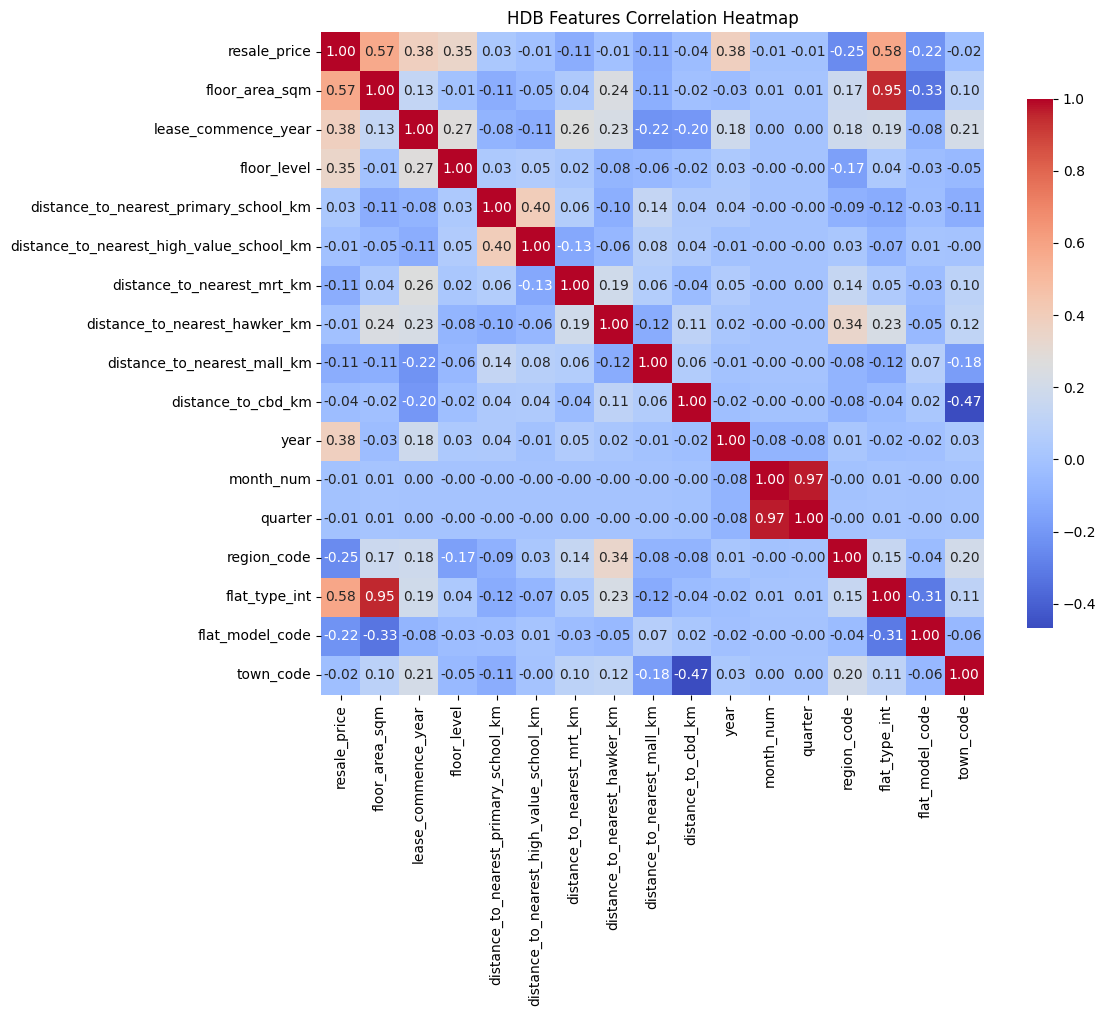

In [18]:
# Reorder columns to put target variable (resale_price) first for better visualization
cols = ['resale_price'] + [c for c in hdb_model.columns if c != 'resale_price']
hdb_model = hdb_model[cols]

# Compute correlation matrix
corr = hdb_model.corr(numeric_only=True)

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    square=True,
    cbar_kws={'shrink': 0.8}
)
plt.title('HDB Features Correlation Heatmap')
plt.tight_layout()
plt.show()

---
## 4. Data Preparation <a id="4-data-preparation"></a>

Create dataset subsets for different modeling scenarios and define the train-test split strategy.

In [19]:
# Create dataset subsets for different analysis scenarios

# Subset: Only common flat types (3-room, 4-room, 5-room)
ds_imp_rooms = hdb_model[hdb_model['flat_type_int'].isin([3, 4, 5])]

# Main dataset: All records
ds_all = hdb_model.copy()

# Subsets by region
ds_region_0 = hdb_model[hdb_model['region_code'] == 0]  # Central
ds_region_1 = hdb_model[hdb_model['region_code'] == 1]  # North/East
ds_region_2 = hdb_model[hdb_model['region_code'] == 2]  # West

# Common flat types split by region
ds_imp_rooms_0 = ds_imp_rooms[ds_imp_rooms['region_code'] == 0]
ds_imp_rooms_1 = ds_imp_rooms[ds_imp_rooms['region_code'] == 1]
ds_imp_rooms_2 = ds_imp_rooms[ds_imp_rooms['region_code'] == 2]

In [20]:
def year_split(df):
    """
    Split dataset into train and test sets based on year.
    Training: data before 2024
    Testing: data from 2024 onwards
    
    Parameters:
        df: DataFrame with 'year' and 'resale_price' columns
    
    Returns:
        X_train, X_test, y_train, y_test
    """
    train = df[df['year'] < 2024]
    test = df[df['year'] >= 2024]
    
    X_train = train.drop(columns=['resale_price'])
    y_train = train['resale_price']
    X_test = test.drop(columns=['resale_price'])
    y_test = test['resale_price']
    
    return X_train, X_test, y_train, y_test


# Create train-test splits for all dataset variants
dataset_names = [
    'imp_rooms', 'imp_rooms_0', 'imp_rooms_1', 'imp_rooms_2',
    'all', 'region_0', 'region_1', 'region_2'
]

dataset_list = [
    ds_imp_rooms, ds_imp_rooms_0, ds_imp_rooms_1, ds_imp_rooms_2,
    ds_all, ds_region_0, ds_region_1, ds_region_2
]

# Store all splits in a dictionary for easy access
splits = {}
for name, dataset in zip(dataset_names, dataset_list):
    X_train, X_test, y_train, y_test = year_split(dataset)
    splits[name] = (X_train, X_test, y_train, y_test)
    print(f"{name}: Train size = {len(X_train)}, Test size = {len(X_test)}")

imp_rooms: Train size = 187394, Test size = 43730
imp_rooms_0: Train size = 36737, Test size = 8326
imp_rooms_1: Train size = 88959, Test size = 19606
imp_rooms_2: Train size = 61698, Test size = 15798
all: Train size = 206303, Test size = 48222
region_0: Train size = 38822, Test size = 8736
region_1: Train size = 98199, Test size = 21638
region_2: Train size = 69282, Test size = 17848


---
## 5. Model Training and Evaluation <a id="5-model-training-and-evaluation"></a>

Train and evaluate three regression models:
- **Linear Regression**: Simple baseline model
- **Random Forest**: Ensemble of decision trees
- **XGBoost**: Gradient boosted trees

In [21]:
# Train and evaluate models across all dataset splits
results = {}

for name, (X_train, X_test, y_train, y_test) in splits.items():
    # Define models to evaluate
    models = {
        'LinearRegression': LinearRegression(),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    }
    
    model_results = {}
    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Generate predictions
        y_pred = model.predict(X_test)
        
        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        model_results[model_name] = {
            'model': model,
            'mae': mae,
            'r2': r2,
            'feature_importance': getattr(model, 'feature_importances_', None)
        }
    
    results[name] = model_results

# Display results for each dataset and model
for ds_name, model_dict in results.items():
    print(f"\n=== Results for dataset: {ds_name} ===")
    for m_name, res in model_dict.items():
        print(f"{m_name}: MAE = ${res['mae']:,.2f}, R² = {res['r2']:.4f}")


=== Results for dataset: imp_rooms ===
LinearRegression: MAE = $85,603.56, R² = 0.6048
RandomForest: MAE = $58,647.86, R² = 0.8438
XGBoost: MAE = $57,405.35, R² = 0.8529

=== Results for dataset: imp_rooms_0 ===
LinearRegression: MAE = $98,258.18, R² = 0.7689
RandomForest: MAE = $72,090.96, R² = 0.8949
XGBoost: MAE = $65,453.73, R² = 0.9135

=== Results for dataset: imp_rooms_1 ===
LinearRegression: MAE = $85,464.62, R² = 0.4355
RandomForest: MAE = $60,870.92, R² = 0.7709
XGBoost: MAE = $60,614.03, R² = 0.7775

=== Results for dataset: imp_rooms_2 ===
LinearRegression: MAE = $58,884.76, R² = 0.5658
RandomForest: MAE = $48,177.96, R² = 0.7409
XGBoost: MAE = $47,297.99, R² = 0.7588

=== Results for dataset: all ===
LinearRegression: MAE = $86,056.08, R² = 0.6460
RandomForest: MAE = $58,975.81, R² = 0.8607
XGBoost: MAE = $57,258.22, R² = 0.8702

=== Results for dataset: region_0 ===
LinearRegression: MAE = $99,101.15, R² = 0.7760
RandomForest: MAE = $71,932.05, R² = 0.9007
XGBoost: MAE =

---
## 6. XGBoost Hyperparameter Tuning <a id="6-xgboost-hyperparameter-tuning"></a>

Use RandomizedSearchCV to find optimal hyperparameters for XGBoost on the full dataset.

In [22]:
# Get train/test split for the 'all' dataset
X_train_all, X_test_all, y_train_all, y_test_all = splits['all']

# Define base XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Define hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],        # L1 regularization
    'reg_lambda': [1, 1.5, 2]        # L2 regularization
}

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=20,                        # Number of parameter combinations to try
    scoring='neg_mean_absolute_error',
    cv=3,                             # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the search
random_search.fit(X_train_all, y_train_all)

print("\n" + "="*50)
print("Best parameters found:")
print(random_search.best_params_)
print(f"\nBest CV MAE: ${-random_search.best_score_:,.2f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=20

In [23]:
# Evaluate the tuned model on test set
best_xgb = random_search.best_estimator_

y_pred_all = best_xgb.predict(X_test_all)
mae_all = mean_absolute_error(y_test_all, y_pred_all)
r2_all = r2_score(y_test_all, y_pred_all)

print(f"Tuned XGBoost Test Performance:")
print(f"  MAE: ${mae_all:,.2f}")
print(f"  R²:  {r2_all:.4f}")

Tuned XGBoost Test Performance:
  MAE: $57,429.41
  R²:  0.8695


---
## 7. Final Model Training and Export <a id="7-final-model-training-and-export"></a>

Train the final model on the complete dataset using optimized hyperparameters and save for deployment.

In [24]:
# Prepare full dataset (train + test) for final model training
X_full = ds_all.drop(columns=['resale_price'])
y_full = ds_all['resale_price']

# Get best parameters and ensure reproducibility settings
best_params = random_search.best_params_.copy()
best_params.update({'random_state': 42, 'n_jobs': -1})

print("Training final model with parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Train final model on complete dataset
final_xgb = xgb.XGBRegressor(**best_params)
final_xgb.fit(X_full, y_full)

print(f"\nFinal model trained on {len(X_full):,} samples")

Training final model with parameters:
  subsample: 0.6
  reg_lambda: 1
  reg_alpha: 0
  n_estimators: 200
  max_depth: 7
  learning_rate: 0.1
  colsample_bytree: 0.6
  random_state: 42
  n_jobs: -1

Final model trained on 254,525 samples


In [25]:
# Save the trained model for deployment
model_path = 'xgb_resale_all.joblib'
joblib.dump(final_xgb, model_path)

print(f"Model saved to: {model_path}")

Model saved to: xgb_resale_all.joblib


Feature Importances:
                                 feature  importance
                             region_code    0.296959
                           flat_type_int    0.177759
                          floor_area_sqm    0.148268
                                    year    0.128672
                     lease_commence_year    0.073423
                             floor_level    0.052227
                         flat_model_code    0.030211
              distance_to_nearest_mrt_km    0.023413
                               town_code    0.021869
                      distance_to_cbd_km    0.013618
             distance_to_nearest_mall_km    0.008992
           distance_to_nearest_hawker_km    0.008243
   distance_to_nearest_primary_school_km    0.005458
distance_to_nearest_high_value_school_km    0.005004
                                 quarter    0.003146
                               month_num    0.002739


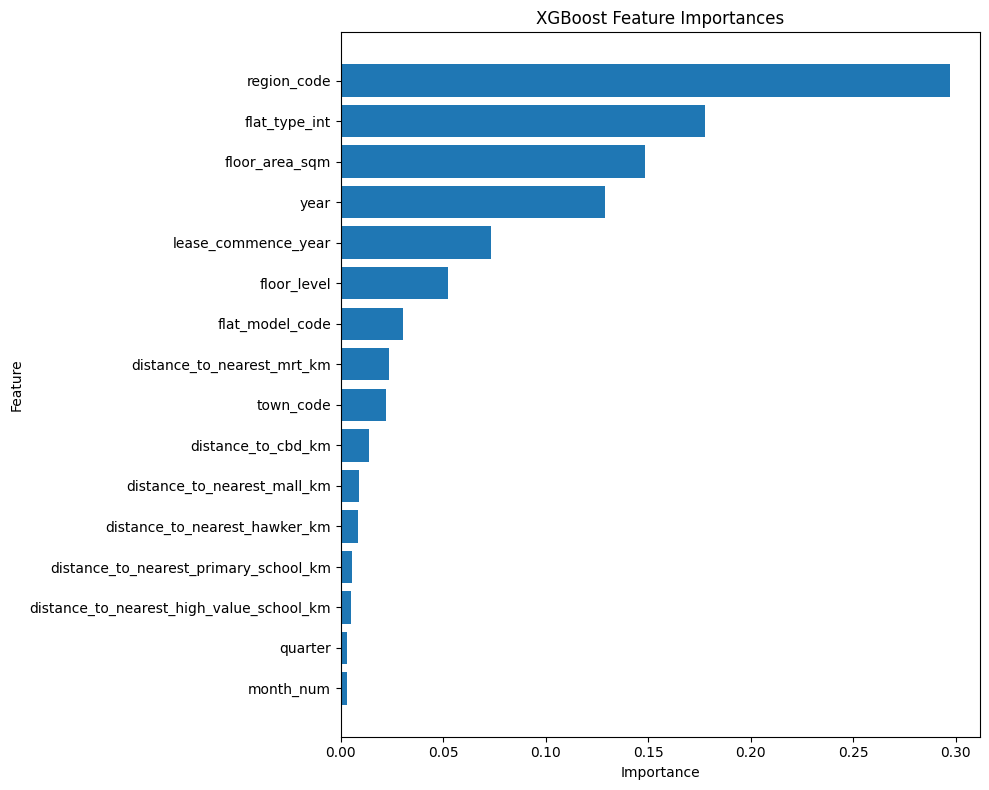

In [26]:
# Display feature importances from the final model
feature_importance = pd.DataFrame({
    'feature': X_full.columns,
    'importance': final_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importances:")
print(feature_importance.to_string(index=False))

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()